In [1]:
# custom module
import topodisc as td

import numpy as np
from numpy import radians as rad
from numpy import degrees as deg
from numpy import sin, cos, tan, arcsin, arccos, arctan, arctan2, mean

import pandas as pd
from dataclasses import dataclass
import itertools

import warnings
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import mean_squared_error

warnings.simplefilter("error", OptimizeWarning)

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

def save_pdf(name: str = 'plot'):
    plt.tight_layout()  # prevent clipping edge labels
    plt.savefig(f'figures/{name}.pdf')

Confirm tilt calculations work as expected.

In [2]:
#td.tilt_check(az1=130, az2=110, sl2=4, legend_position=(.34, .5))
#td.tilt_check(az1=130, az2=230, sl2=2, legend_position=(0.34, 0.7))

## Map Data

In [2]:
map_path = "../GEOL192-GIS/data/"

centers = pd.read_csv(f'{map_path}centers.csv').set_index('cID')
samples = pd.read_csv(f'{map_path}samples.csv').set_index('sID')

cIDs = centers.index.tolist()
sIDs = samples.index.tolist()

feature_sIDs = {
    'flow': samples.index[samples['FEATURE'] == 'flow'].tolist(),
    'channel': samples.index[samples['FEATURE'] == 'channel'].tolist(),
}

POP_A_sIDs = [
    198, 438, 439, 440, 441, 442, 443, 444, 445, 490, 491, 492, 493
]

POP_B_sIDs = [
    193, 194, 195, 196, 197, 477, 478, 479, 480, 481, 544, 545, 548, 549
]

POP_C_sIDs = [
    529, 530, 531, 532, 533, 537, 538, 539, 540, 541, 542, 543
]

pop_all = td.Population(name='all', sIDs=sIDs)
pop_flow = td.Population(name='flow', sIDs=feature_sIDs['flow'])
pop_channel = td.Population(name='channel', sIDs=feature_sIDs['channel'])

pop_a = td.Population(name='A', sIDs=POP_A_sIDs)
pop_b = td.Population(name='B', sIDs=POP_B_sIDs)
pop_c = td.Population(name='C', sIDs=POP_C_sIDs)

Calculate tilt (etc.) for each sample, repeat for each center. Full dataset from which to pull subsets later.

In [3]:
# ensure default values before computing results for analytical fit
td.MAX_EPV = 7e22
td.TEST_D = 20_000
td.AZ1_UNCERTAINTY = 7

centers_calc = {
    cID: td.make_center(cID, centers, samples) for cID in cIDs
}

(-6.0, 1.0)

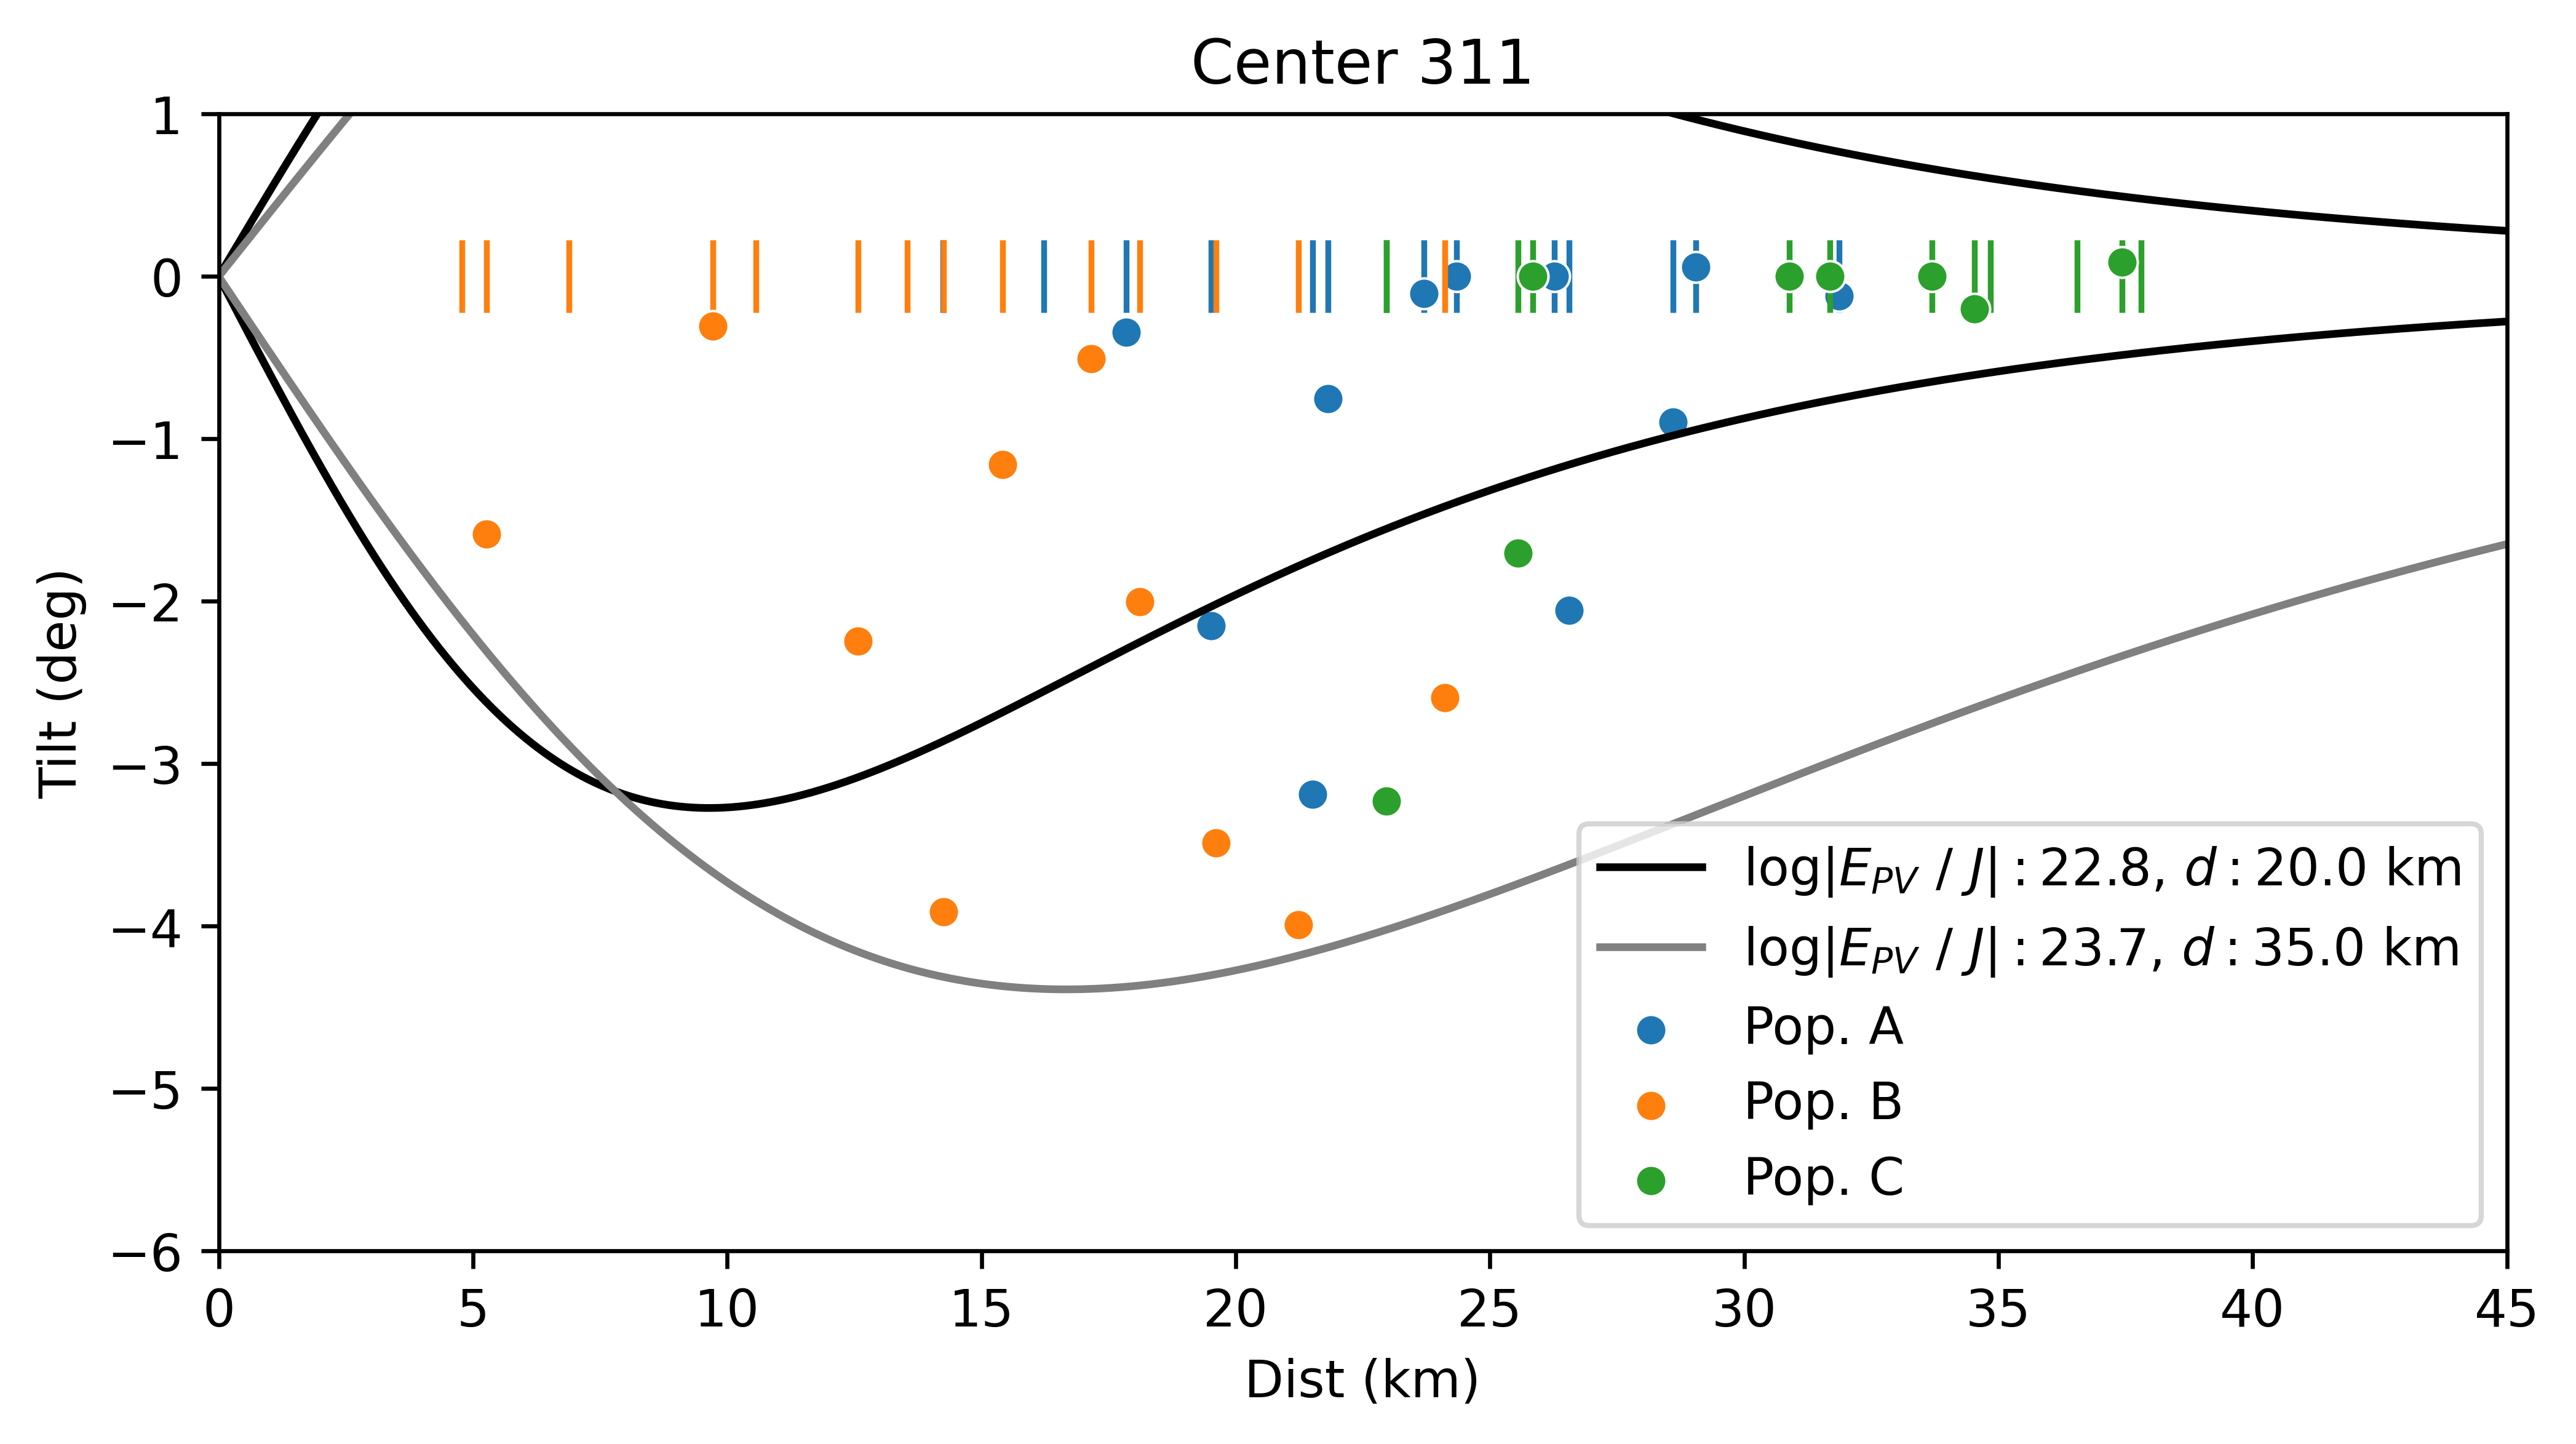

In [7]:
plt.figure(figsize=(8, 4), dpi=600)

# default envelope

td.MAX_EPV = 7e22
td.TEST_D = 20_000
td.plot_envelope()

# custom envelope for this dataset to exclude outliers
td.MAX_EPV = 5e23  # higher than default
td.TEST_D = 35_000  # deeper than default
td.plot_envelope(color='grey')

centers_calc[311].plot_tilt(
    [pop_a, pop_b, pop_c],
    exclude_untiltable=True
)

plt.xlabel('Dist (km)')
plt.ylabel('Tilt (deg)')

plt.title('Center 311')

plt.xlim(0, 45)
plt.ylim(-6,1)

# save_pdf('results/center-311-scatter-all') # if exclude_untiltable = False
# save_pdf('results/center-311-scatter-no-outliers') # if exclude_untiltable = True

Text(0.5, 1.0, 'Center 76')

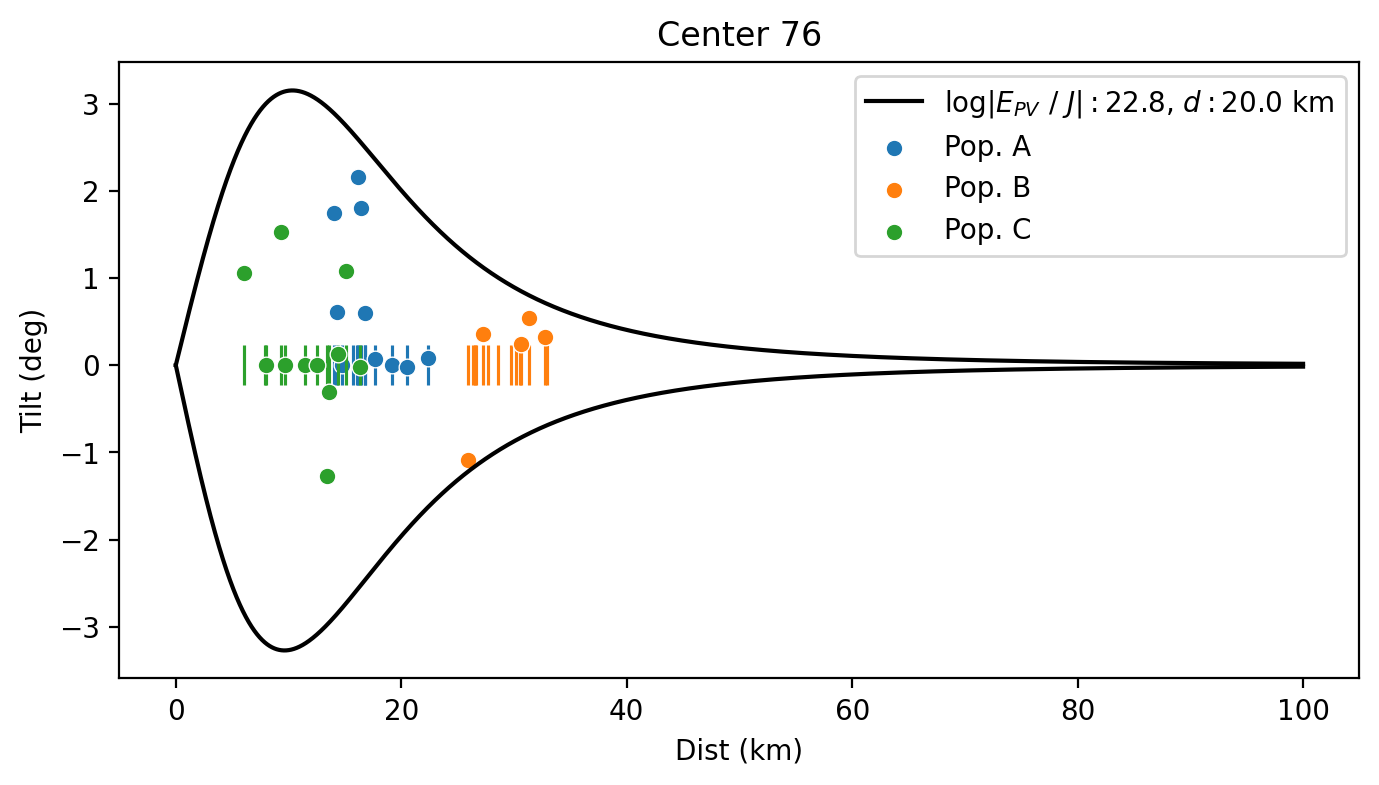

In [59]:
cID = 76

plt.figure(figsize=(8, 4), dpi=200)

# default envelope

td.MAX_EPV = 7e22
td.TEST_D = 20_000
td.plot_envelope()

centers_calc[cID].plot_tilt(
    [pop_a, pop_b, pop_c],
    exclude_untiltable=False
)

plt.xlabel('Dist (km)')
plt.ylabel('Tilt (deg)')

plt.title(f'Center {cID}')

# plt.xlim(0, 45)
# plt.ylim(-1,6)

# save_pdf(f'results/center-{cID}-scatter-all') # if exclude_untiltable = False
# save_pdf(f'results/center-{cID-scatter-no-outliers') # if exclude_untiltable = True

Define criteria for evaluation.

Define criteria and perform evaluation. This takes a few minutes on my machine.

In [9]:
criteria = [
    #td.Criterion(td.summit_score, pop_all),
    #td.Criterion(td.summit_score, pop_flow),
    #td.Criterion(td.summit_score, pop_channel),
    td.Criterion(td.inflation_score, pop_a),
    td.Criterion(td.inflation_score, pop_b),
    td.Criterion(td.inflation_score, pop_c),
]

scores = {}
score_names = []

# note: will get score name out of order if any criteria throw errors, so those need to be handled in each evaluation function
for cID in [76, 311]:

    center = centers_calc[cID]
    centers_eval = []

    for crit in criteria:
        center_crit_scores = td.evaluate_center(center, crit)

        for key, val in center_crit_scores.items():
            centers_eval.append(val)

            full_score_name = f'{crit.pop.name}_{key}'

            if full_score_name not in score_names:
                score_names.append(full_score_name)
                
    scores[cID] = centers_eval

Write evaluation to disk.

In [15]:
# centers_eval = pd.DataFrame(scores).transpose().set_axis(score_names, axis=1)


# centers_eval_no_infs = centers_eval.replace([np.inf, -np.inf], np.nan)

# centers_eval_no_infs.to_csv(
#     f'{map_path}centers_eval.csv',
#     index_label='cID'
# )

## Model data

Define parameter combinations.

In [61]:
grav_topo_test_params = {
    "depth": [15_000],
    "radius": [20_000],
    "aspect": [.4],
    "pmult": [.6],
    "grav": [True, False],
    "topo": [True, False],
}

mogi_shallow_oblate_test_params = {
    "depth": [15_000, 20000],
    "radius": [20_000],
    "aspect": [.4],
    "pmult": [.6],
    "grav": [False],
    "topo": [True],
}

mogi_test_params = {
    "depth": [25_000],
    "radius": [5_000],
    "aspect": [1],
    "pmult": [1],
    "grav": [False],
    "topo": [False],
}

In [5]:
coarse_params_shallow = {
    "depth": [4_000, 8_000, 12_000],
    "radius": [5_000, 10_000],
    "aspect": [0.2, 0.5, 0.7],
    "pmult": [-1, -0.5, 0.5, 1],
    "grav": [False],
    "topo": [True],
}

coarse_params_deep = {
    "depth": [16_000, 20_000, 24_000], # 25
    "radius": [20_000, 25_000, 30_000], # 5
    "aspect": [0.2, 0.3, 0.5],
    "pmult": [-1, 1, 2],
    "grav": [False],
    "topo": [True],
}

full_coarse_sweep = td.ParamSweep(
    td.unpack_param_combinations(coarse_params_shallow) 
    + td.unpack_param_combinations(coarse_params_deep)
)

153

In [6]:
len(full_coarse_sweep.models)

153

In [12]:
oblate_deflation_params = {
    "depth": [8000, 9000, 10_000, 11_000, 12_000], # 25
    "radius": [25_000, 26_000, 27_000], # 5
    "aspect": [0.1, 0.15, 0.2, 0.25],
    "pmult": [-0.5, -0.75, -1, -1.25, -1.5],
    "grav": [False],
    "topo": [True],
}

oblate_deep_deflation_params = {
    "depth": [12_000, 14_000, 16_000], # 25
    "radius": [24_000, 26_000, 28_000, 30_000], # 5
    "aspect": [0.1, 0.15, 0.2, 0.25],
    "pmult": [-0.75, -1, -1.25, -1.5, -1.75],
    "grav": [False],
    "topo": [True],
}

oblate_inflation_params = {
    "depth": [8000, 9000, 10_000, 11_000, 12_000], # 25
    "radius": [10_000, 26_000, 27_000], # 5
    "aspect": [0.1, 0.15, 0.2, 0.25],
    "pmult": [-0.5, -0.75, -1, -1.25, -1.5],
    "grav": [False],
    "topo": [True],
}

oblate_deflation_sweep = td.ParamSweep(
    td.unpack_param_combinations(oblate_deflation_params)
    + td.unpack_param_combinations(oblate_deep_deflation_params)
)

NumericalModel(params={'depth': 8000, 'radius': 27000, 'aspect': 0.1, 'pmult': -0.75, 'grav': False, 'topo': True}, rmse=1.1053711085322733)
NumericalModel(params={'depth': 9000, 'radius': 27000, 'aspect': 0.1, 'pmult': -1, 'grav': False, 'topo': True}, rmse=1.106268382428675)
NumericalModel(params={'depth': 9000, 'radius': 26000, 'aspect': 0.1, 'pmult': -1.25, 'grav': False, 'topo': True}, rmse=1.1082833117112807)


Text(0.5, 1.0, 'Center 311')

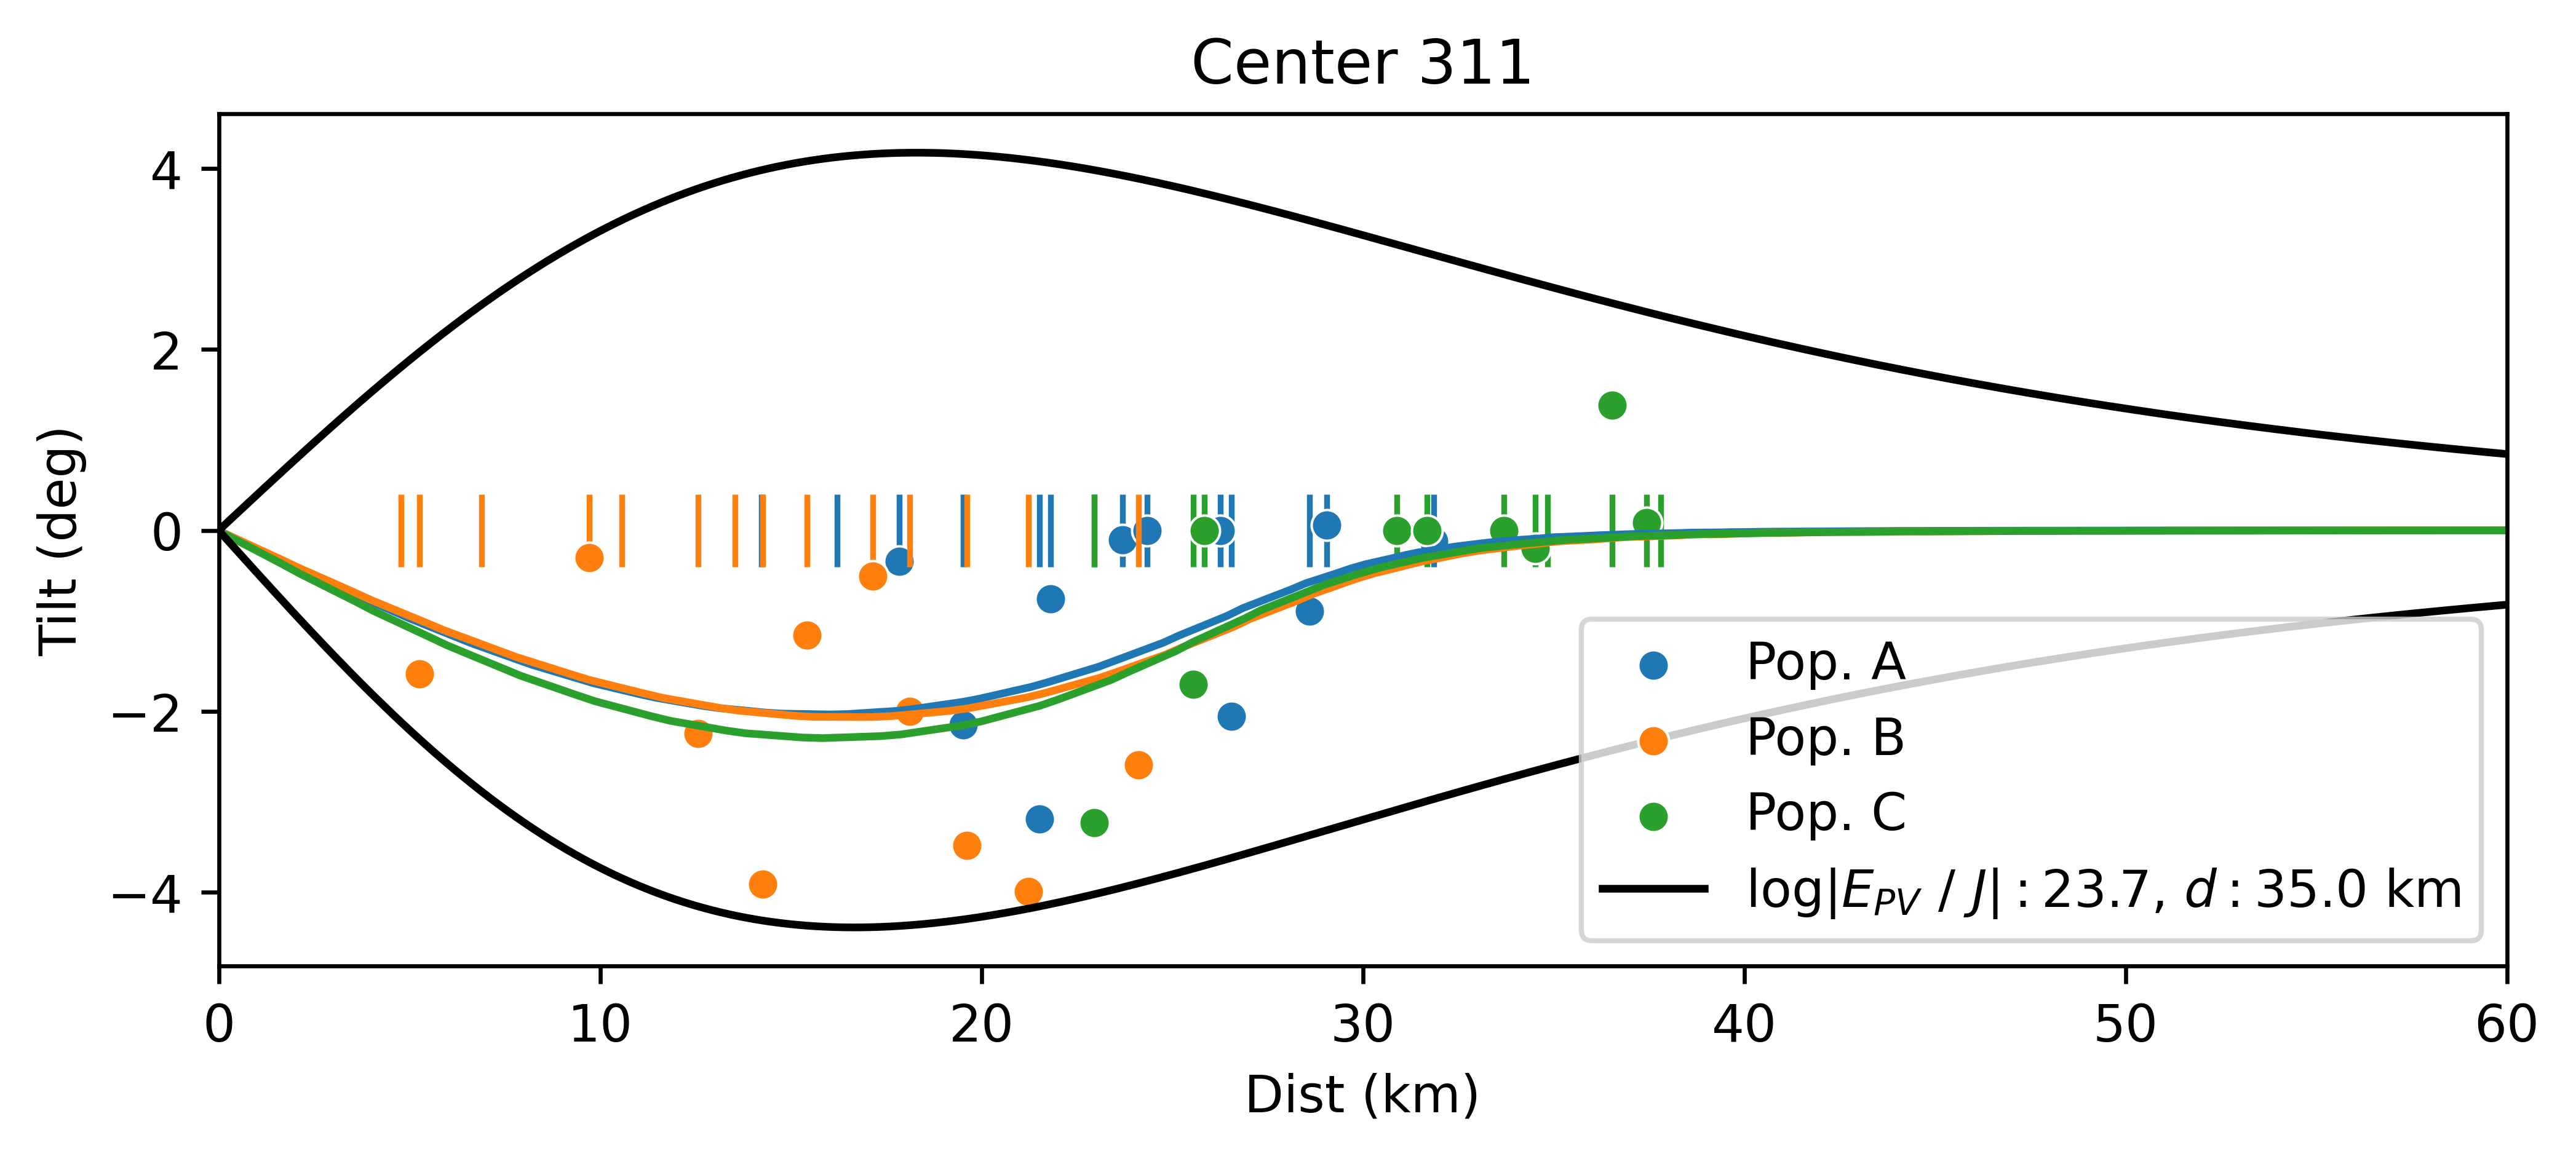

In [21]:
cID = 311

oblate_deflation_sweep.sort_models_by_rmse(
    center=centers_calc[cID],
    pops=[pop_a, pop_b, pop_c],
    tiltable_only=True
    )

plt.figure(figsize=(8,3), dpi=600)

for model in oblate_deflation_sweep.models[:3]:
    print(model)
    model.plot_numerical_tilt()

plt.ylabel('Tilt (deg)')
plt.xlabel('Dist (km)')
plt.xlim(0, 50)

# make a new higher cutoff function to use for excluding untiltables

td.MAX_EPV = 5e23 # three orders of magnitude higher than default
td.TEST_D = 35_000 # deeper than default

centers_calc[cID].plot_tilt(
    [pop_a, pop_b, pop_c],
    exclude_untiltable=True
)

td.plot_envelope()
plt.legend(loc='lower right')
plt.xlim(0,60)

plt.title(f'Center {cID}')

In [16]:
len(oblate_deflation_sweep.models)

540